In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
import xgboost as xgb

In [2]:
df = pd.read_csv('AEP_hourly.csv')
df

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0
...,...,...
121268,2018-01-01 20:00:00,21089.0
121269,2018-01-01 21:00:00,20999.0
121270,2018-01-01 22:00:00,20820.0
121271,2018-01-01 23:00:00,20415.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  121273 non-null  object 
 1   AEP_MW    121273 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


In [4]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.set_index('Datetime')

In [5]:
df

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0
...,...
2018-01-01 20:00:00,21089.0
2018-01-01 21:00:00,20999.0
2018-01-01 22:00:00,20820.0


In [6]:
df.index = pd.to_datetime(df.index)


<Axes: xlabel='Datetime'>

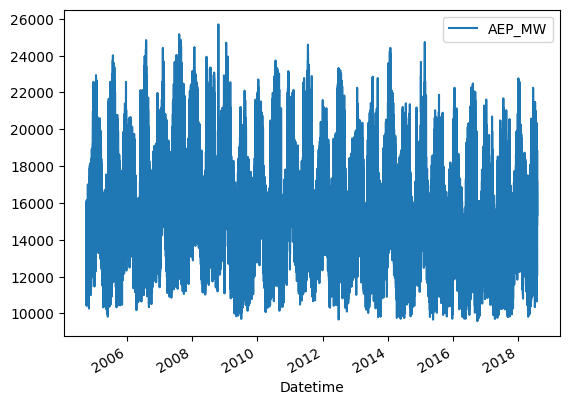

In [7]:
df.plot()

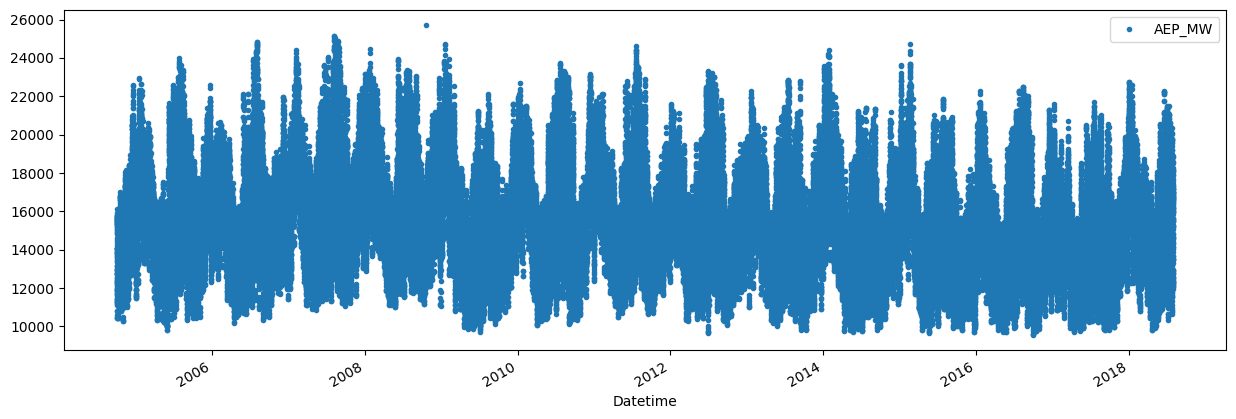

In [8]:
df.plot(style = '.',
        figsize = (15,5), color=color_pal[0])
plt.show()

In [9]:
df.index

DatetimeIndex(['2004-12-31 01:00:00', '2004-12-31 02:00:00',
               '2004-12-31 03:00:00', '2004-12-31 04:00:00',
               '2004-12-31 05:00:00', '2004-12-31 06:00:00',
               '2004-12-31 07:00:00', '2004-12-31 08:00:00',
               '2004-12-31 09:00:00', '2004-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=121273, freq=None)

## Train/Test Split

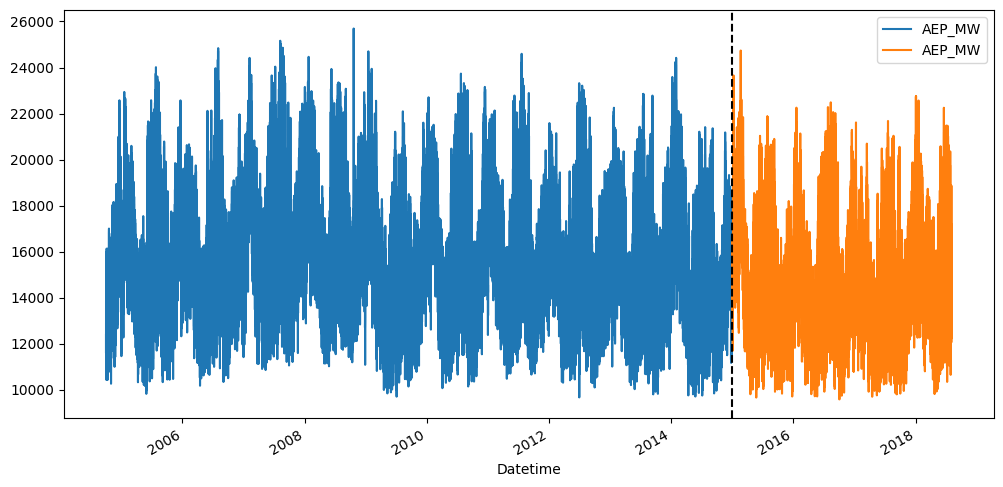

In [10]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index  >= '01-01-2015']

fig, ax = plt.subplots(figsize = (12,6))
train.plot(ax=ax, label = 'Training Set')
test.plot(ax=ax, label = 'Testing Set')
ax.axvline('01-01-2015', color='black', ls='--')
plt.show()

<Axes: xlabel='Datetime'>

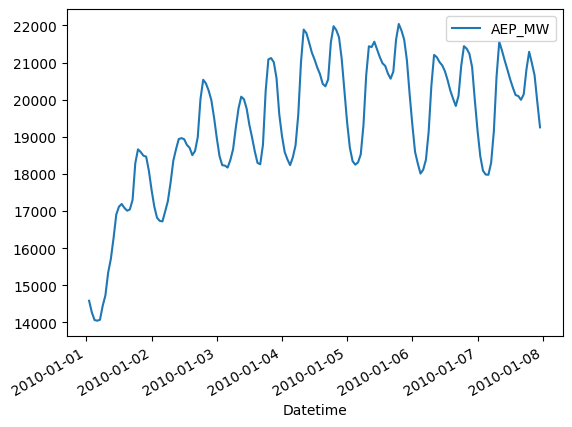

In [11]:
# 1 week data
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot()

## Feature Creation

In [12]:
def create_features(df):
  df = df.copy()
  df['hour'] = df.index.hour
  df['dayofweek'] = df.index.dayofweek
  df['quarter'] = df.index.quarter
  df['month'] = df.index.month
  df['year'] = df.index.year
  df['dayofyear'] = df.index.dayofyear
  return df


df = create_features(df)

# Visualize

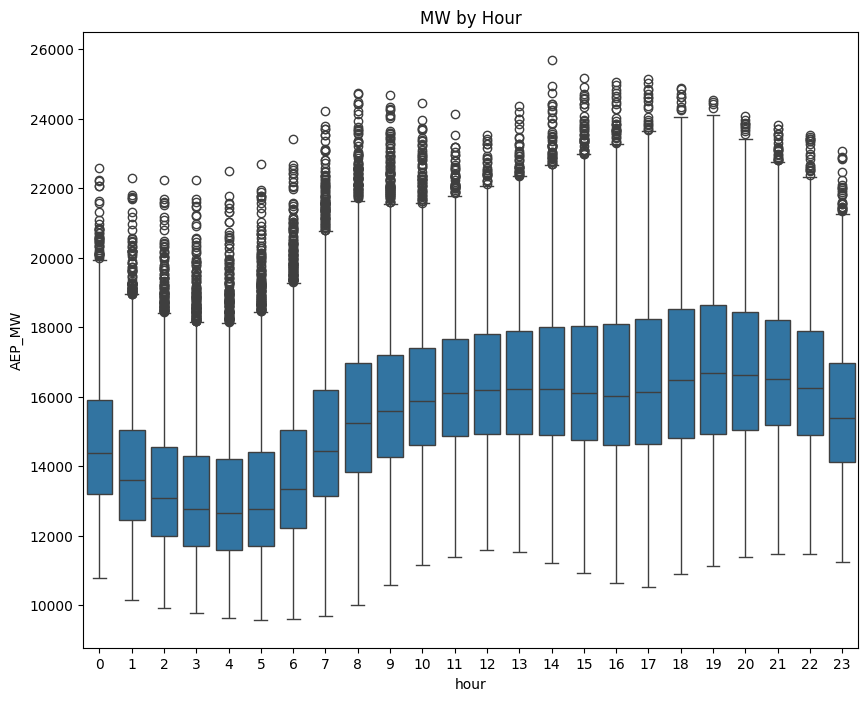

In [13]:
fig.ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x= 'hour', y='AEP_MW')
plt.title('MW by Hour')
plt.show()

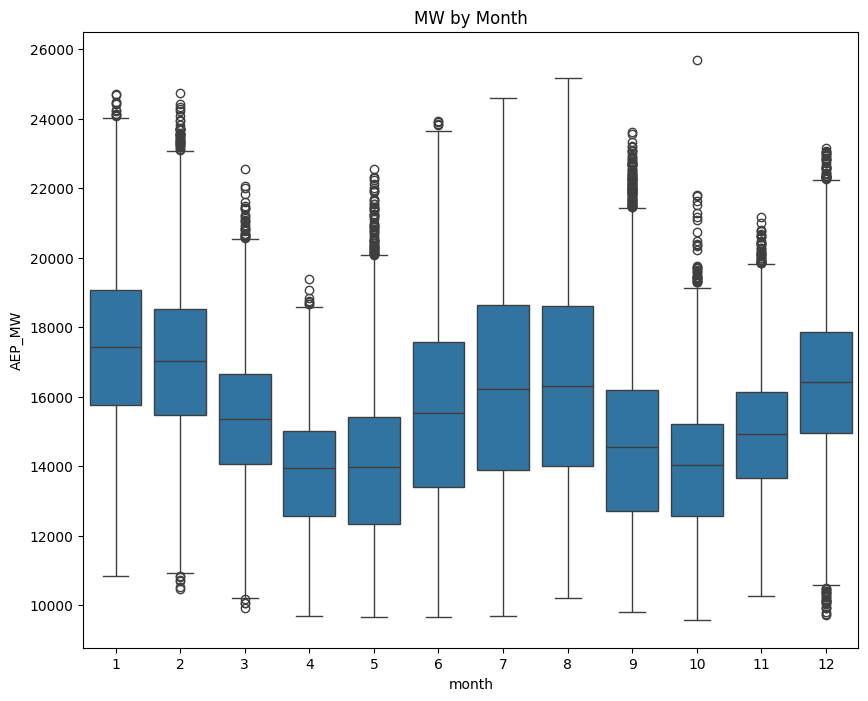

In [14]:
fig.ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x= 'month', y='AEP_MW')
plt.title('MW by Month')
plt.show()

## Model Building

In [15]:
from sklearn.metrics import mean_squared_error

In [16]:
train = create_features(train)
test = create_features(test)

In [17]:
df.columns

Index(['AEP_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear'], dtype='object')

In [18]:
Features = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
target = ['AEP_MW']

In [19]:
X_train = train[Features]
y_train = train[target]

X_test = test[Features]
y_test = test[target]



In [20]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds = 50,
                       learning_rate = 0.001)
reg.fit(X_train, y_train,
        eval_set = [(X_train, y_train), (X_test, y_test)],
        verbose = 100)

[0]	validation_0-rmse:2571.77747	validation_1-rmse:2683.12724
[100]	validation_0-rmse:2418.78537	validation_1-rmse:2543.72673
[200]	validation_0-rmse:2285.21737	validation_1-rmse:2424.24267
[300]	validation_0-rmse:2168.46028	validation_1-rmse:2320.84646
[400]	validation_0-rmse:2066.27063	validation_1-rmse:2231.99828
[500]	validation_0-rmse:1977.35291	validation_1-rmse:2156.44867
[600]	validation_0-rmse:1900.68213	validation_1-rmse:2095.13001
[700]	validation_0-rmse:1832.44385	validation_1-rmse:2040.87265
[800]	validation_0-rmse:1772.78374	validation_1-rmse:1993.65343
[900]	validation_0-rmse:1720.60363	validation_1-rmse:1949.47821
[999]	validation_0-rmse:1674.54889	validation_1-rmse:1911.14625


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Feature Importance

In [21]:
pd.DataFrame(data = reg.feature_importances_,
             index = reg.feature_names_in_)

,0
hour,0.388902
dayofweek,0.168613
quarter,0.031443
month,0.246689
year,0.027089
dayofyear,0.137264


## Forecast on Test

In [22]:
test['prediction'] = reg.predict(X_test)

In [23]:
test['prediction']

Datetime
2015-01-01 00:00:00    15923.991211
2015-12-31 01:00:00    14933.623047
2015-12-31 02:00:00    14924.480469
2015-12-31 03:00:00    14924.480469
2015-12-31 04:00:00    14924.480469
                           ...     
2018-01-01 20:00:00    17807.367188
2018-01-01 21:00:00    17807.367188
2018-01-01 22:00:00    17796.468750
2018-01-01 23:00:00    17527.636719
2018-01-02 00:00:00    15923.991211
Name: prediction, Length: 31440, dtype: float32

In [24]:
df = df.merge(test['prediction'], how='left', left_index = True, right_index=True)

In [25]:
df

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,prediction
Datetime,,,,,,,,
2004-10-01 01:00:00,12379.0,1,4,4,10,2004,275,NaN
2004-10-01 02:00:00,11935.0,2,4,4,10,2004,275,NaN
2004-10-01 03:00:00,11692.0,3,4,4,10,2004,275,NaN
2004-10-01 04:00:00,11597.0,4,4,4,10,2004,275,NaN
2004-10-01 05:00:00,11681.0,5,4,4,10,2004,275,NaN
...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,17673.0,20,3,3,8,2018,214,17471.023438
2018-08-02 21:00:00,17303.0,21,3,3,8,2018,214,17471.023438
2018-08-02 22:00:00,17001.0,22,3,3,8,2018,214,17471.023438


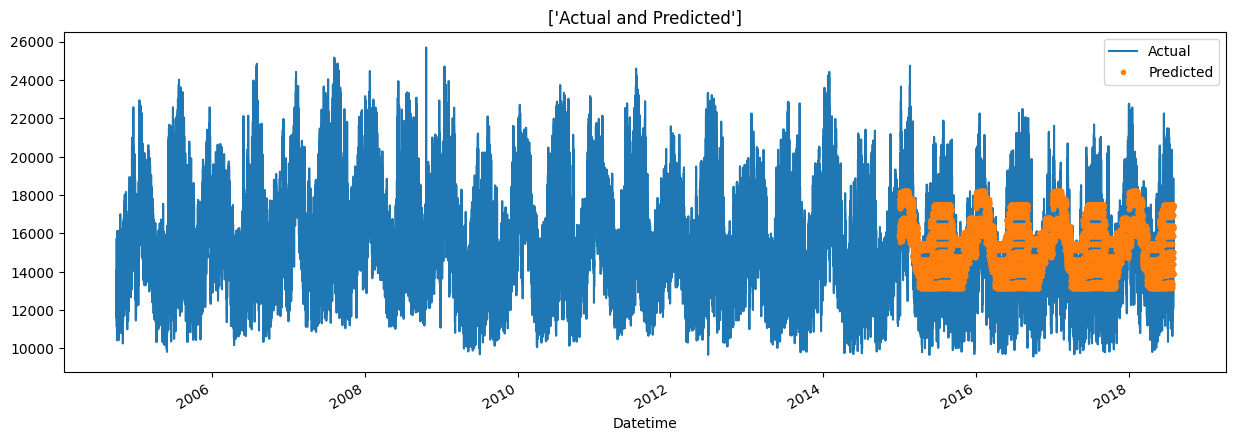

In [26]:
ax = df[['AEP_MW']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Actual', 'Predicted'])
ax.set_title(['Actual and Predicted'])
plt.show()

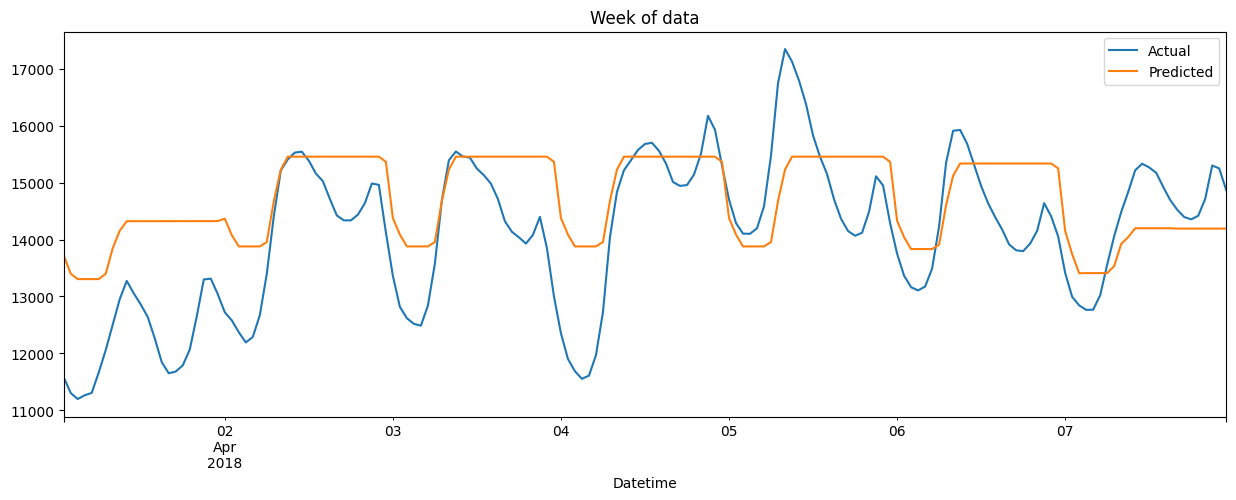

In [29]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['AEP_MW'] \
.plot(figsize=(15,5), title = 'Week of data')

ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
.plot(style = '-')
plt.legend(['Actual', 'Predicted'])
plt.show()

In [30]:
score = np.sqrt(mean_squared_error(test['AEP_MW'], test['prediction']))
print(f'RMSE Score on Test Set : {score : 0.2f}')


RMSE Score on Test Set :  1911.15
